In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

In [59]:
# Let's generate some reproducible, pseudorandom normally-distributed data for our 2 populations
# Naturally, math majors have higher average GPA than stats majors (ha ha)
np.random.seed(42)

math_GPAs = np.random.normal(3.7, 0.5, size=20)
stats_GPAs = np.random.normal(2.8, 0.15, size=20)
# Clip the generated GPAs to ensure they fall within the range [0.0, 4.0]
math_GPAs = np.clip(math_GPAs, 0.0, 4.0)
stats_GPAs = np.clip(stats_GPAs, 0.0, 4.0)
mixture_data = np.concatenate((math_GPAs, stats_GPAs))
np.random.shuffle(mixture_data)

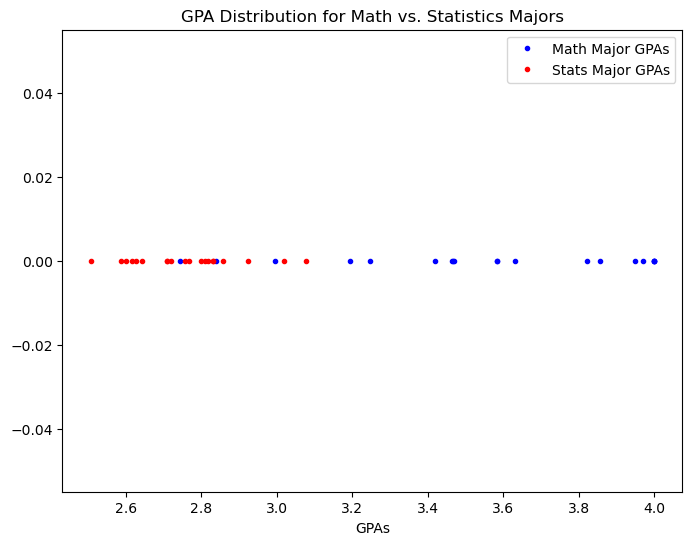

In [60]:
# true distribution
val = 0 # this is the value where you want the data to appear on the y-axis.
plt.figure(figsize=(8, 6))
math2 = plt.plot(math_GPAs, np.zeros_like(math_GPAs) + val, '.', color = 'blue', label='Math Major GPAs')
stats = plt.plot(stats_GPAs, np.zeros_like(stats_GPAs) + val, '.', color='red', label='Stats Major GPAs')
plt.legend()
plt.title('GPA Distribution for Math vs. Statistics Majors')
plt.xlabel('GPAs')
plt.show()

In [61]:
print(mixture_data)

[3.63086785 3.58292331 3.58293152 4.         3.46829115 3.19358444
 4.         2.50604948 2.83132954 3.46713512 2.7099042  2.62735096
 2.75624594 4.         3.24598796 3.94835708 2.99384815 2.76613355
 3.46526281 2.58628777 2.60077209 2.79797542 2.82952919 3.82098114
 3.41885624 3.01984732 3.07784173 2.71834259 2.8563547  2.81012923
 2.92338174 4.         2.83754108 2.70974401 2.74335988 2.61687345
 3.97128002 2.64134336 2.81663839 3.85712367]


Text(0.5, 0, 'GPAs')

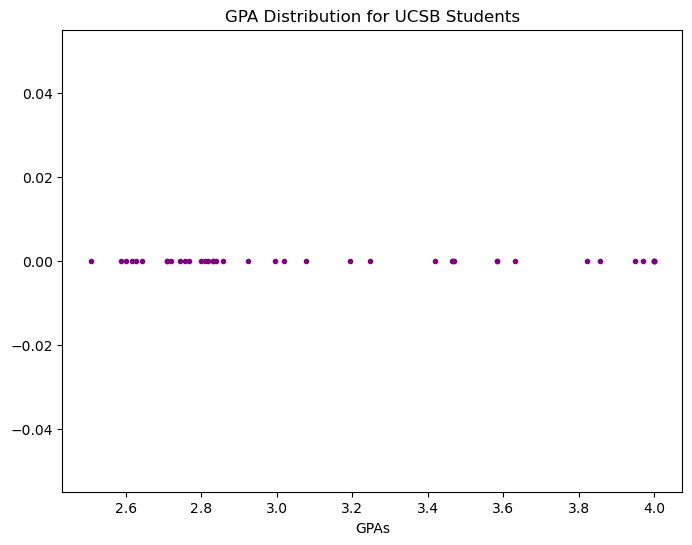

In [62]:
# perceived distribution
plt.figure(figsize=(8, 6))
plt.plot(mixture_data, np.zeros_like(mixture_data) + val, '.', color = 'purple')
plt.title('GPA Distribution for UCSB Students')
plt.xlabel('GPAs')

In [63]:
def E_step(data, params):
    (math_likelihood, stats_likelihood, mu_math, mu_stats, sigma_math, sigma_stats) = params
    # assume normal dist, compute joint log-likelihoods of dataset
    likelihood_math = norm.pdf(data, loc=mu_math, scale=sigma_math)
    log_likelihood_math = np.log(likelihood_math)
    likelihood_stats = norm.pdf(data, loc=mu_stats, scale=sigma_stats)
    log_likelihood_stats = np.log(likelihood_stats)
    prob_math = (likelihood_math / (likelihood_math + likelihood_stats))
    prob_stats = (likelihood_stats / (likelihood_math + likelihood_stats))
    return (prob_math, prob_stats, mu_math, mu_stats, sigma_math, sigma_stats)

In [64]:
def M_step(data, params):
    (prob_math, prob_stats, mu_math, mu_stats, sigma_math, sigma_stats) = params
    # refer to the example of MLE for the 1-dim normal distribution in Chapter 1
    # of the paper for the below formulas
    mu_hat_math = np.sum(prob_math * data) / np.sum(prob_math)
    sigma_hat_math = np.sqrt(np.sum(prob_math * (data - mu_math)**2) / np.sum(prob_math))
    mu_hat_stats = np.sum(prob_stats * data) / np.sum(prob_stats)
    sigma_hat_stats = np.sqrt(np.sum(prob_stats * (data - mu_stats)**2) / np.sum(prob_stats))
    return (prob_math, prob_stats, mu_hat_math, mu_hat_stats, sigma_hat_math, sigma_hat_stats)

In [76]:
def M_step_alt(data, params, learning_rate=0.05):
    (prob_math, prob_stats, mu_math, mu_stats, sigma_math, sigma_stats) = params
    d_mu_math = (2*len(data) * (np.mean(data * prob_math) - mu_math)) / (2 * sigma_math**2)
    d_sigma_math = 1/len(data) * (np.sum(prob_math * data**2) - len(data) * np.mean(data * prob_math)**2)
    d_mu_stats = (2*len(data) * (np.mean(data * prob_stats) - mu_stats)) / (2 * sigma_stats**2)
    d_sigma_stats = 1/len(data) * (np.sum(prob_stats * data**2) - len(data) * np.mean(data * prob_stats)**2)
    mu_hat_math = mu_math + learning_rate * d_mu_math
    sigma_hat_math = sigma_math + learning_rate * d_sigma_math
    mu_hat_stats = mu_stats + learning_rate * d_mu_stats
    sigma_hat_stats = sigma_stats + learning_rate * d_sigma_stats
    return (prob_math, prob_stats, mu_hat_math, mu_hat_stats, sigma_hat_math, sigma_hat_stats)

In [66]:
def EM_algorithm(data, max_iterations = 100):
    # random initialization of parameters for our 2 distributions
    np.random.seed(0)
    mu_math = np.random.uniform(0,4)
    sigma_math = np.random.uniform(0,1)
    mu_stats = np.random.uniform(0,4)
    sigma_stats = np.random.uniform(0,1)
    print(mu_math, sigma_math, mu_stats, sigma_stats)
    num_iterations = 0
    params = (data, data, mu_math, mu_stats, sigma_math, sigma_stats)
    while num_iterations < 1000:
        (prob_math, prob_stats, mu_math, mu_stats, sigma_math, sigma_stats) = params
        params = E_step(data, params)
        params = M_step(data, params)
        num_iterations += 1
        if (math.fabs(params[2] - mu_math) < 0.0001 and math.fabs(params[3] - mu_stats) < 0.0001 \
        and math.fabs(params[4] - sigma_math) < 0.0001 and math.fabs(params[5] - sigma_stats) < 0.0001):
            break
    print(num_iterations)
    return params

In [67]:
EM_algorithm(mixture_data)

2.195254015709299 0.7151893663724195 2.4110535042865755 0.5448831829968969
32


(array([1.        , 1.        , 1.        , 1.        , 0.99999944,
        0.982717  , 1.        , 0.00800749, 0.0248728 , 0.99999941,
        0.00868755, 0.00650361, 0.01190043, 1.        , 0.99672008,
        1.        , 0.25962722, 0.0129066 , 0.99999936, 0.00641311,
        0.00638158, 0.01732599, 0.02435904, 1.        , 0.99999522,
        0.37704049, 0.69867944, 0.00912562, 0.03376365, 0.01964368,
        0.08693005, 1.        , 0.02676112, 0.00867975, 0.01078515,
        0.00642736, 1.        , 0.00666509, 0.02107183, 1.        ]),
 array([1.92642244e-10, 2.32689892e-09, 2.32593014e-09, 1.69207670e-20,
        5.55824088e-07, 1.72829967e-02, 1.69207670e-20, 9.91992507e-01,
        9.75127197e-01, 5.85355945e-07, 9.91312449e-01, 9.93496390e-01,
        9.88099573e-01, 1.69207670e-20, 3.27992028e-03, 6.59349847e-19,
        7.40372779e-01, 9.87093397e-01, 6.36457770e-07, 9.93586891e-01,
        9.93618424e-01, 9.82674014e-01, 9.75640959e-01, 3.06858131e-15,
        4.78192901e-06

In [79]:
def EM_algorithm2(data, max_iterations = 100):
    # random initialization of parameters for our 2 distributions
    np.random.seed(0)
    mu_math = np.random.uniform(0,4)
    sigma_math = np.random.uniform(0,1)
    mu_stats = np.random.uniform(0,4)
    sigma_stats = np.random.uniform(0,1)
    print(mu_math, sigma_math, mu_stats, sigma_stats)
    num_iterations = 0
    params = (data, data, mu_math, mu_stats, sigma_math, sigma_stats)
    while num_iterations < 1000:
        (prob_math, prob_stats, mu_math, mu_stats, sigma_math, sigma_stats) = params
        params = E_step(data, params)
        params = M_step_alt(data, params)
        num_iterations += 1
        print(params[2])
        if (math.fabs(params[2] - mu_math) < 0.0001 and math.fabs(params[3] - mu_stats) < 0.0001 \
        and math.fabs(params[4] - sigma_math) < 0.0001 and math.fabs(params[5] - sigma_stats) < 0.0001):
            break
    print(num_iterations)
    return params

In [80]:
EM_algorithm2(mixture_data)

2.195254015709299 0.7151893663724195 2.4110535042865755 0.5448831829968969
-0.22190832072437772
9.040359262402136
-6.604105725913625
18.654547237191764
-20.321992822755192
37.15085347707135
-43.81385242882507
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

C:\Users\sammy\AppData\Local\Temp\ipykernel_11156\2265533054.py:7: RuntimeWarning: divide by zero encountered in log
  log_likelihood_stats = np.log(likelihood_stats)
C:\Users\sammy\AppData\Local\Temp\ipykernel_11156\2265533054.py:5: RuntimeWarning: divide by zero encountered in log
  log_likelihood_math = np.log(likelihood_math)
C:\Users\sammy\AppData\Local\Temp\ipykernel_11156\2265533054.py:8: RuntimeWarning: invalid value encountered in divide
  prob_math = (likelihood_math / (likelihood_math + likelihood_stats))
C:\Users\sammy\AppData\Local\Temp\ipykernel_11156\2265533054.py:9: RuntimeWarning: invalid value encountered in divide
  prob_stats = (likelihood_stats / (likelihood_math + likelihood_stats))


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan]),
 nan,
 nan,
 nan,
 nan)